In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)
import warnings
warnings.filterwarnings("ignore")

Read the Credit Card Default Dataset (This Dataset is downloaded from UCI Machine Learning Repository)

Link to the Dataset :- https://archive.ics.uci.edu/ml/machine-learning-databases/00350/

In [2]:
data=pd.read_excel("default of credit card clients.xls")

Let's have a glimpse of the dataset

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Perform all the data pre-processing steps as done earlier in GBM

In [6]:
X_train, X_test, y_train, y_test=train_test_split(data,data['default payment next month'],
                                                  stratify=data['default payment next month'], 
                                                  test_size=0.2, random_state=42)

In [8]:
cols_to_encode=['SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
enc = TargetEncoder(cols=cols_to_encode).fit(X_train, X_train['default payment next month'])
X_train_encoded = enc.transform(X_train)
X_test_encoded = enc.transform(X_test)

In [10]:
cols=[col for col in X_train_encoded.columns if col not in ['ID','default payment next month']]
minmax = MinMaxScaler()
X_train_encoded_std = pd.DataFrame(minmax.fit_transform(X_train_encoded[cols]),columns=cols)
X_test_encoded_std = pd.DataFrame(minmax.transform(X_test_encoded[cols]),columns=cols)            

In [11]:
dtrain = xgb.DMatrix(X_train_encoded_std, label = y_train)
dtest = xgb.DMatrix(X_test_encoded_std, label = y_test)

In [12]:
param = {'max_depth':3, 'eta':0.1, 'objective':'binary:logistic' }
num_round = 100
bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtrain)

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_pred)

0.8063609996839783

In [14]:
preds_test = bst.predict(dtest)
roc_auc_score(y_test,preds_test)

0.7754050872825032

There are 23 columns and we have to impose linearity constraint on PAY_3 which is at position 7

Setting variable monotonicity constraints

0: No constraint, 

1: Positive, 
    
-1: Negative

In [16]:
params_constrained = param.copy()
params_constrained['monotone_constraints'] = "(0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)"

In [17]:
num_round = 100
bst = xgb.train(params_constrained, dtrain, num_round)
y_pred = bst.predict(dtrain)
roc_auc_score(y_train,y_pred)

0.8056083683286994

In [18]:
preds_test = bst.predict(dtest)
roc_auc_score(y_test,preds_test)

0.7763347653977838

As you can see that the difference between train and test AUC is reduced after imposing the linearity constraint

So it is helping us to prevent the model from learning noise in the data and thereby generalize on unseen data

In [58]:
def partial_dependency(bst, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()

    grid = np.linspace(np.percentile(X_temp.iloc[:, f_id], 0.1),
                       np.percentile(X_temp.iloc[:, f_id], 99.5),
                       500)
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X_temp.iloc[:, f_id] = val
            data = xgb.DMatrix( X_temp.loc[:, feature_ids] )
            y_pred[i] = np.average(bst.predict(data, ntree_limit = bst.best_ntree_limit))

    return grid, y_pred

IndexError: single positional indexer is out-of-bounds

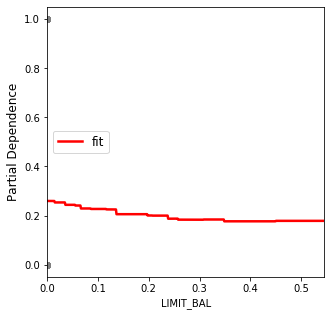

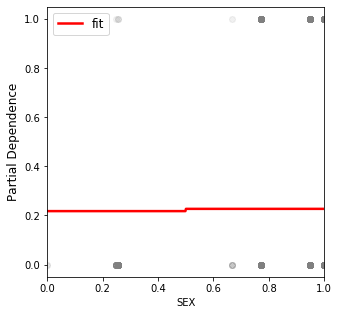

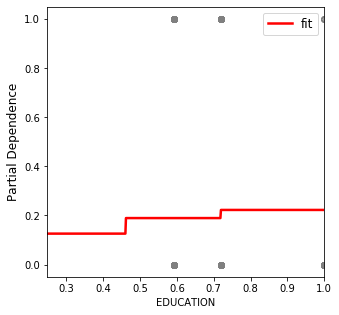

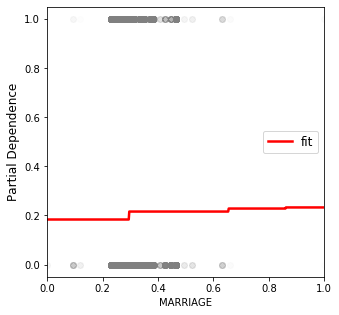

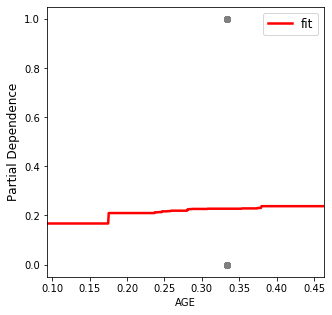

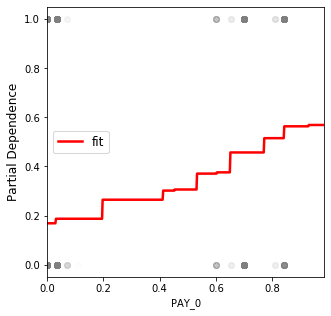

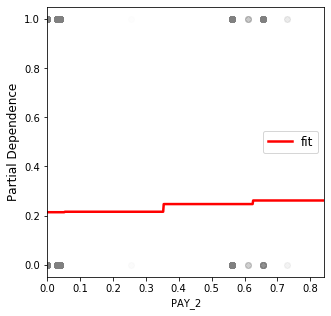

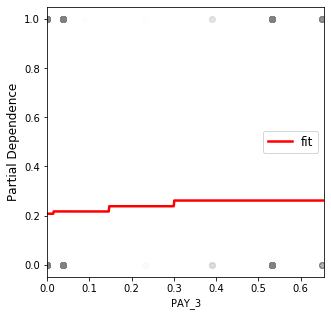

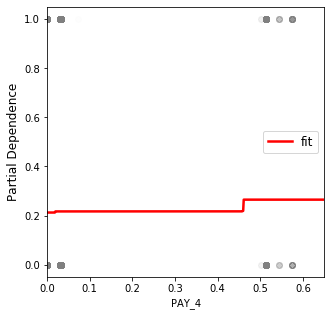

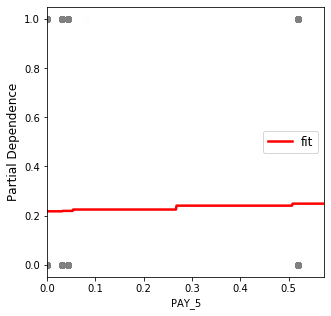

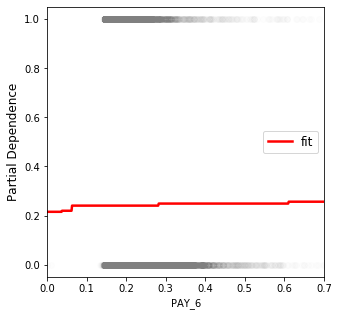

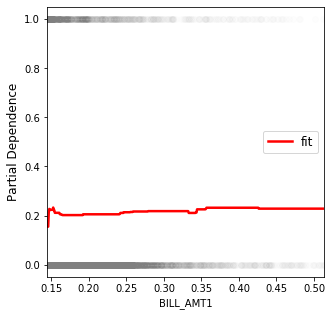

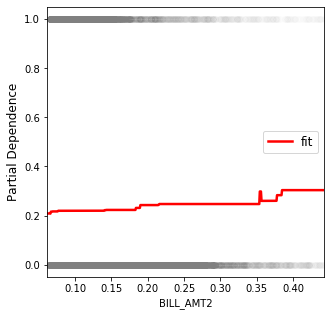

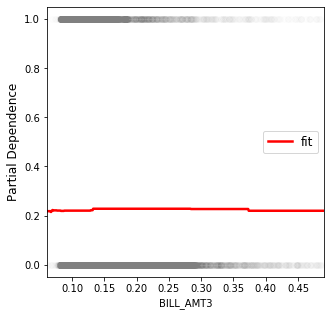

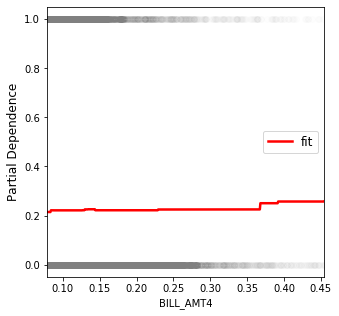

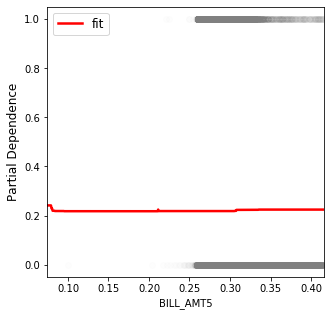

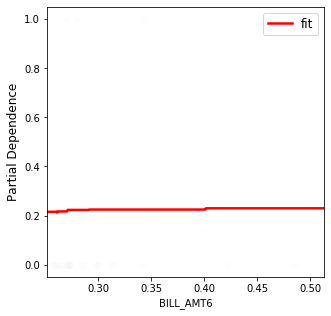

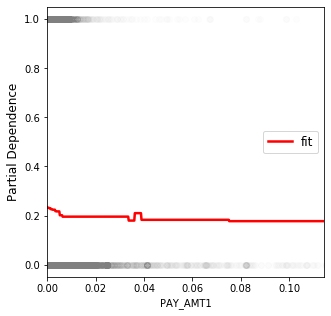

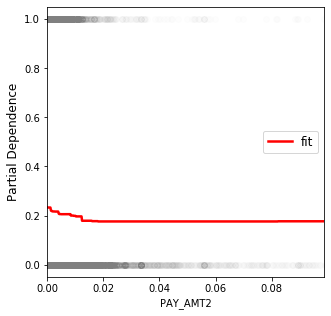

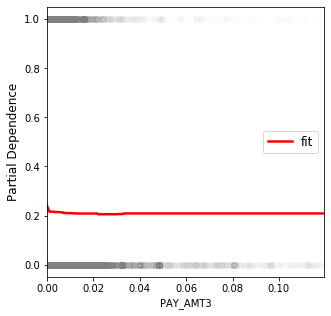

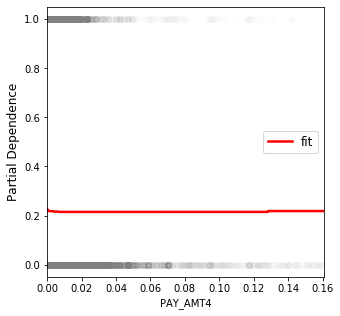

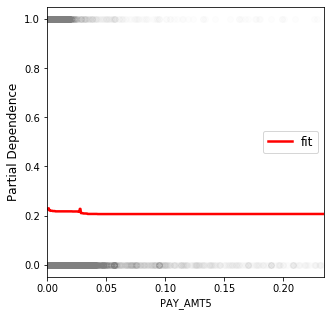

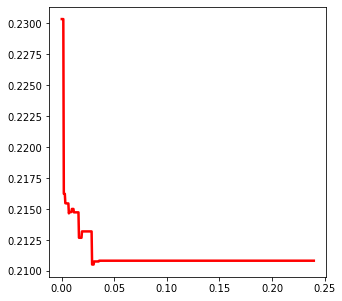

In [59]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for f in cols:

    grid, y_pred = partial_dependency(bst,
                                      X_train_encoded_std,
                                      y_train,
                                      feature_ids = cols,
                                      f_id = X_train_encoded_std.columns.get_loc(f)
                                     )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, '-', color = 'red', linewidth = 2.5, label='fit')
    ax.plot(X_train_encoded_std.iloc[:, X_train.columns.get_loc(f)], y_train, 'o', color = 'grey', alpha = 0.01)

    ax.set_xlim(min(grid), max(grid))
    ax.set_xlabel(f, fontsize = 10)
    ax.set_ylabel('Partial Dependence', fontsize = 12)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc = 'best', fontsize = 12)

We want to make sure that the model does not learn any interaction between SEX & MARRIAGE.

And as seen previously they were interacting amongst themselves and not with any other feature

So ideally they should not interact with any variables

Features 1 (SEX) and 3 (MARRIAGE) are allowed to interact with themselves but with no other feature

In [68]:
params_constrained['interaction_constraints'] = '[[1], [3]]'

In [111]:
num_round = 100
bst = xgb.train(params_constrained, dtrain, num_round)
preds = bst.predict(dtrain)

In [70]:
roc_auc_score(y_train,preds)

0.7877025615476222

In [71]:
preds_test = bst.predict(dtest)
roc_auc_score(y_test,preds_test)

0.765299978019926

As you can see that the difference between train and test AUC is reduced more after imposing the interaction constraint

So both these constraints are acting as regularizers and helping the model to generalize well

In [82]:
from __future__ import print_function, division

import argparse
import sys
import re
import xlsxwriter


_comparer = None


def FeatureScoreComparer(sortingMetric):
    global _comparer
    _comparer = {
        'gain': lambda x: -x.Gain,
        'fscore': lambda x: -x.FScore,
        'fscoreweighted': lambda x: -x.FScoreWeighted,
        'fscoreweightedaverage': lambda x: -x.FScoreWeightedAverage,
        'averagegain': lambda x: -x.AverageGain,
        'expectedgain': lambda x: -x.ExpectedGain
    }[sortingMetric.lower()]


class SplitValueHistogram:
    def __init__(self):
        self.values = {}

    def AddValue(self, splitValue, count):
        if not (splitValue in self.values):
            self.values[splitValue] = 0
        self.values[splitValue] += count

    def Merge(self, histogram):
        for key in histogram.values.keys():
            self.AddValue(key, histogram.values[key])


class FeatureInteraction:
    def __init__(self, interaction, gain, cover, pathProbability, depth, treeIndex, fScore=1):
        self.SplitValueHistogram = SplitValueHistogram()

        features = sorted(interaction, key=lambda x: x.Feature)
        self.Name = "|".join(x.Feature for x in features)

        self.Depth = len(interaction) - 1
        self.Gain = gain
        self.Cover = cover
        self.FScore = fScore
        self.FScoreWeighted = pathProbability

        self.AverageFScoreWeighted = self.FScoreWeighted / self.FScore
        self.AverageGain = self.Gain / self.FScore
        self.ExpectedGain = self.Gain * pathProbability
        self.TreeIndex = treeIndex
        self.TreeDepth = depth
        self.AverageTreeIndex = self.TreeIndex / self.FScore
        self.AverageTreeDepth = self.TreeDepth / self.FScore
        self.HasLeafStatistics = False

        if self.Depth == 0:
            self.SplitValueHistogram.AddValue(interaction[0].SplitValue, 1)

        self.SumLeafValuesLeft = 0.0
        self.SumLeafCoversLeft = 0.0
        self.SumLeafValuesRight = 0.0
        self.SumLeafCoversRight = 0.0

    def __lt__(self, other):
        return self.Name < other.Name


class FeatureInteractions:
    def __init__(self):
        self.Count = 0
        self.interactions = {}

    def GetFeatureInteractionsOfDepth(self, depth):
        return sorted([self.interactions[key] for key in self.interactions.keys() if self.interactions[key].Depth == depth], key=_comparer)

    def GetFeatureInteractionsWithLeafStatistics(self):
        return sorted([self.interactions[key] for key in self.interactions.keys() if self.interactions[key].HasLeafStatistics], key=_comparer)

    def Merge(self, other):
        for key in other.interactions.keys():
            fi = other.interactions[key]
            if not (key in self.interactions):
                self.interactions[key] = fi
            else:
                self.interactions[key].Gain += fi.Gain
                self.interactions[key].Cover += fi.Cover
                self.interactions[key].FScore += fi.FScore
                self.interactions[key].FScoreWeighted += fi.FScoreWeighted
                self.interactions[key].AverageFScoreWeighted = self.interactions[key].FScoreWeighted / self.interactions[key].FScore
                self.interactions[key].AverageGain = self.interactions[key].Gain / self.interactions[key].FScore
                self.interactions[key].ExpectedGain += fi.ExpectedGain
                self.interactions[key].SumLeafCoversLeft += fi.SumLeafCoversLeft
                self.interactions[key].SumLeafCoversRight += fi.SumLeafCoversRight
                self.interactions[key].SumLeafValuesLeft += fi.SumLeafValuesLeft
                self.interactions[key].SumLeafValuesRight += fi.SumLeafValuesRight
                self.interactions[key].TreeIndex += fi.TreeIndex
                self.interactions[key].AverageTreeIndex = self.interactions[key].TreeIndex / self.interactions[key].FScore
                self.interactions[key].TreeDepth += fi.TreeDepth
                self.interactions[key].AverageTreeDepth = self.interactions[key].TreeDepth / self.interactions[key].FScore

                self.interactions[key].SplitValueHistogram.Merge(fi.SplitValueHistogram)


class XgbModel:
    def __init__(self, verbosity=0):
        self._verbosity = verbosity
        self.XgbTrees = []
        self._treeIndex = 0
        self._maxDeepening = 0
        self._pathMemo = []
        self._maxInteractionDepth = 0

    def AddTree(self, tree):
        self.XgbTrees.append(tree)

    def GetFeatureInteractions(self, maxInteractionDepth, maxDeepening):
        xgbFeatureInteractions = FeatureInteractions()
        self._maxInteractionDepth = maxInteractionDepth
        self._maxDeepening = maxDeepening

        if self._verbosity >= 1:
            if self._maxInteractionDepth == -1:
                print("Collectiong feature interactions")
            else:
                print("Collectiong feature interactions up to depth {}".format(self._maxInteractionDepth))

        for i, tree in enumerate(self.XgbTrees):
            if self._verbosity >= 2:
                sys.stdout.write("Collectiong feature interactions within tree #{} ".format(i + 1))

            self._treeFeatureInteractions = FeatureInteractions()
            self._pathMemo = []
            self._treeIndex = i

            treeNodes = []
            self.CollectFeatureInteractions(tree, treeNodes, currentGain=0.0, currentCover=0.0, pathProbability=1.0, depth=0, deepening=0)

            if self._verbosity >= 2:
                sys.stdout.write("=> number of interactions: {}\n".format(len(self._treeFeatureInteractions.interactions)))
            xgbFeatureInteractions.Merge(self._treeFeatureInteractions)

        if self._verbosity >= 1:
            print("{} feature interactions has been collected.".format(len(xgbFeatureInteractions.interactions)))

        return xgbFeatureInteractions

    def CollectFeatureInteractions(self, tree, currentInteraction, currentGain, currentCover, pathProbability, depth, deepening):
        if tree.node.IsLeaf:
            return

        currentInteraction.append(tree.node)
        currentGain += tree.node.Gain
        currentCover += tree.node.Cover

        pathProbabilityLeft = pathProbability * (tree.left.node.Cover / tree.node.Cover)
        pathProbabilityRight = pathProbability * (tree.right.node.Cover / tree.node.Cover)

        fi = FeatureInteraction(currentInteraction, currentGain, currentCover, pathProbability, depth, self._treeIndex, 1)

        if (depth < self._maxDeepening) or (self._maxDeepening < 0):
            newInteractionLeft = []
            newInteractionRight = []

            self.CollectFeatureInteractions(tree.left, newInteractionLeft, 0.0, 0.0, pathProbabilityLeft, depth + 1, deepening + 1)
            self.CollectFeatureInteractions(tree.right, newInteractionRight, 0.0, 0.0, pathProbabilityRight, depth + 1, deepening + 1)

        path = ",".join(str(n.Number) for n in currentInteraction)

        if not (fi.Name in self._treeFeatureInteractions.interactions):
            self._treeFeatureInteractions.interactions[fi.Name] = fi
            self._pathMemo.append(path)
        else:
            if path in self._pathMemo:
                return
            self._pathMemo.append(path)

            tfi = self._treeFeatureInteractions.interactions[fi.Name]
            tfi.Gain += currentGain
            tfi.Cover += currentCover
            tfi.FScore += 1
            tfi.FScoreWeighted += pathProbability
            tfi.AverageFScoreWeighted = tfi.FScoreWeighted / tfi.FScore
            tfi.AverageGain = tfi.Gain / tfi.FScore
            tfi.ExpectedGain += currentGain * pathProbability
            tfi.TreeDepth += depth
            tfi.AverageTreeDepth = tfi.TreeDepth / tfi.FScore
            tfi.TreeIndex += self._treeIndex
            tfi.AverageTreeIndex = tfi.TreeIndex / tfi.FScore
            tfi.SplitValueHistogram.Merge(fi.SplitValueHistogram)

        if (len(currentInteraction) - 1 == self._maxInteractionDepth):
            return

        currentInteractionLeft = list(currentInteraction)
        currentInteractionRight = list(currentInteraction)

        leftTree = tree.left
        rightTree = tree.right

        if (leftTree.node.IsLeaf and (deepening == 0)):
            tfi = self._treeFeatureInteractions.interactions[fi.Name]
            tfi.SumLeafValuesLeft += leftTree.node.LeafValue
            tfi.SumLeafCoversLeft += leftTree.node.Cover
            tfi.HasLeafStatistics = True

        if (rightTree.node.IsLeaf and (deepening == 0)):
            tfi = self._treeFeatureInteractions.interactions[fi.Name]
            tfi.SumLeafValuesRight += rightTree.node.LeafValue
            tfi.SumLeafCoversRight += rightTree.node.Cover
            tfi.HasLeafStatistics = True

        self.CollectFeatureInteractions(tree.left, currentInteractionLeft, currentGain, currentCover, pathProbabilityLeft, depth + 1, deepening)
        self.CollectFeatureInteractions(tree.right, currentInteractionRight, currentGain, currentCover, pathProbabilityRight, depth + 1, deepening)


class XgbTreeNode:
    def __init__(self):
        self.Feature = ''
        self.Gain = 0.0
        self.Cover = 0.0
        self.Number = -1
        self.LeftChild = None
        self.RightChild = None
        self.LeafValue = 0.0
        self.SplitValue = 0.0
        self.IsLeaf = False

    def __lt__(self, other):
        return self.Number < other.Number


class XgbTree:
    def __init__(self, node):
        self.left = None
        self.right = None
        self.node = node  # or node.copy()


class XgbModelParser:
    def __init__(self, verbosity=0):
        self._verbosity = verbosity
        self.nodeRegex = re.compile(r'(\d+):\[(.*?)(?:<(.+)|)\]\syes=(.*),no=(.*?),(?:missing=.*,)?gain=(.*),cover=(.*)')
        self.leafRegex = re.compile(r'(\d+):leaf=(.*),cover=(.*)')

    def ConstructXgbTree(self, tree):
        if tree.node.LeftChild is not None:
            tree.left = XgbTree(self.xgbNodeList[tree.node.LeftChild])
            self.ConstructXgbTree(tree.left)
        if tree.node.RightChild is not None:
            tree.right = XgbTree(self.xgbNodeList[tree.node.RightChild])
            self.ConstructXgbTree(tree.right)

    def ParseXgbTreeNode(self, line):
        node = XgbTreeNode()

        m = self.leafRegex.match(line)
        if m:
            node.Number = int(m.group(1))
            node.LeafValue = float(m.group(2))
            node.Cover = float(m.group(3))
            node.IsLeaf = True
        else:
            m = self.nodeRegex.match(line)
            node.Number = int(m.group(1))
            node.Feature = m.group(2)
            # split on boolean if m.group(3) is not captured
            node.SplitValue = float(m.group(3)) if m.group(3) else 0.5
            node.LeftChild = int(m.group(4))
            node.RightChild = int(m.group(5))
            node.Gain = float(m.group(6))
            node.Cover = float(m.group(7))
            node.IsLeaf = False
        return node

    def GetXgbModelFromFile(self, fileName, maxTrees):
        model = XgbModel(self._verbosity)
        self.xgbNodeList = {}
        numTree = 0
        with open(fileName) as f:
            for line in f:
                line = line.strip()
                if (not line) or line.startswith('booster'):
                    if any(self.xgbNodeList):
                        numTree += 1
                        if self._verbosity >= 2:
                            sys.stdout.write("Constructing tree #{}\n".format(numTree))
                        tree = XgbTree(self.xgbNodeList[0])
                        self.ConstructXgbTree(tree)

                        model.AddTree(tree)
                        self.xgbNodeList = {}
                        if numTree == maxTrees:
                            if self._verbosity >= 1:
                                print('maxTrees reached')
                            break
                else:
                    node = self.ParseXgbTreeNode(line)
                    if not node:
                        return None
                    self.xgbNodeList[node.Number] = node

            if any(self.xgbNodeList) and ((maxTrees < 0) or (numTree < maxTrees)):
                numTree += 1
                if self._verbosity >= 2:
                    sys.stdout.write("Constructing tree #{}\n".format(numTree))
                tree = XgbTree(self.xgbNodeList[0])
                self.ConstructXgbTree(tree)

                model.AddTree(tree)
                self.xgbNodeList = {}

        return model

    def GetXgbModelFromMemory(self, dump, maxTrees):
        model = XgbModel(self._verbosity)
        self.xgbNodeList = {}
        numTree = 0
        for booster_line in dump:
            self.xgbNodeList = {}
            for line in booster_line.split('\n'):
                line = line.strip()
                if not line:
                    continue
                node = self.ParseXgbTreeNode(line)
                if not node:
                    return None
                self.xgbNodeList[node.Number] = node
            numTree += 1
            tree = XgbTree(self.xgbNodeList[0])
            self.ConstructXgbTree(tree)
            model.AddTree(tree)
            if numTree == maxTrees:
                break
        return model


def rankInplace(a):
    c = [(j, i[0]) for j, i in enumerate(sorted(enumerate(a), key=lambda x:x[1]))]
    c.sort(key=lambda x: x[1])
    return [i[0] for i in c]


def FeatureInteractionsWriter(FeatureInteractions, fileName, MaxDepth, topK, MaxHistograms, verbosity=0):

    if verbosity >= 1:
        print("Writing {}".format(fileName))

    workbook = xlsxwriter.Workbook(fileName)

    cf_first_row = workbook.add_format()
    cf_first_row.set_align('center')
    cf_first_row.set_align('vcenter')
    cf_first_row.set_bold(True)

    cf_first_column = workbook.add_format()
    cf_first_column.set_align('center')
    cf_first_column.set_align('vcenter')

    cf_num = workbook.add_format()
    cf_num.set_num_format('0.00')

    for depth in range(MaxDepth + 1):
        if verbosity >= 1:
            print("Writing feature interactions with depth {}".format(depth))

        interactions = FeatureInteractions.GetFeatureInteractionsOfDepth(depth)

#        KTotalGain = sum([i.Gain for i in interactions])
#        TotalCover = sum([i.Cover for i in interactions])
#        TotalFScore = sum([i.FScore for i in interactions])
#        TotalFScoreWeighted = sum([i.FScoreWeighted for i in interactions])
#        TotalFScoreWeightedAverage = sum([i.AverageFScoreWeighted for i in interactions])

        if topK > 0:
            interactions = interactions[0:topK]

        if not interactions:
            break

        ws = workbook.add_worksheet("Interaction Depth {}".format(depth))

        ws.set_row(0, 20, cf_first_row)

        ws.set_column(0, 0, max([len(i.Name) for i in interactions]) + 10, cf_first_column)

        ws.set_column(1, 13, 17)
        ws.set_column(10, 11, 18)
        ws.set_column(12, 12, 19)
        ws.set_column(13, 13, 17, cf_num)
        ws.set_column(14, 15, 19, cf_num)

        for col, name in enumerate(["Interaction", "Gain", "FScore", "wFScore", "Average wFScore",
                                    "Average Gain", "Expected Gain", "Gain Rank", "FScore Rank",
                                    "wFScore Rank", "Avg wFScore Rank", "Avg Gain Rank",
                                    "Expected Gain Rank", "Average Rank", "Average Tree Index",
                                    "Average Tree Depth"]):
            ws.write(0, col, name)

        gainSorted = rankInplace([-f.Gain for f in interactions])
        fScoreSorted = rankInplace([-f.FScore for f in interactions])
        fScoreWeightedSorted = rankInplace([-f.FScoreWeighted for f in interactions])
        averagefScoreWeightedSorted = rankInplace([-f.AverageFScoreWeighted for f in interactions])
        averageGainSorted = rankInplace([-f.AverageGain for f in interactions])
        expectedGainSorted = rankInplace([-f.ExpectedGain for f in interactions])

        for i, fi in enumerate(interactions):
            ws.write(i + 1, 0, fi.Name)
            ws.write(i + 1, 1, fi.Gain)
            ws.write(i + 1, 2, fi.FScore)
            ws.write(i + 1, 3, fi.FScoreWeighted)
            ws.write(i + 1, 4, fi.AverageFScoreWeighted)
            ws.write(i + 1, 5, fi.AverageGain)
            ws.write(i + 1, 6, fi.ExpectedGain)
            ws.write(i + 1, 7, 1 + gainSorted[i])
            ws.write(i + 1, 8, 1 + fScoreSorted[i])
            ws.write(i + 1, 9, 1 + fScoreWeightedSorted[i])
            ws.write(i + 1, 10, 1 + averagefScoreWeightedSorted[i])
            ws.write(i + 1, 11, 1 + averageGainSorted[i])
            ws.write(i + 1, 12, 1 + expectedGainSorted[i])
            ws.write(i + 1, 13, (6.0 + gainSorted[i] + fScoreSorted[i] + fScoreWeightedSorted[i] + averagefScoreWeightedSorted[i] + averageGainSorted[i] + expectedGainSorted[i]) / 6.0)
            ws.write(i + 1, 14, fi.AverageTreeIndex)
            ws.write(i + 1, 15, fi.AverageTreeDepth)

    interactions = FeatureInteractions.GetFeatureInteractionsWithLeafStatistics()
    if interactions:
        if verbosity >= 1:
            print("Writing leaf statistics")

        ws = workbook.add_worksheet("Leaf Statistics")

        ws.set_row(0, 20, cf_first_row)
        ws.set_column(0, 0, max([len(i.Name) for i in interactions]) + 10, cf_first_column)
        ws.set_column(1, 4, 20)

        for col, name in enumerate(["Interaction", "Sum Leaf Values Left", "Sum Leaf Values Right",
                                   "Sum Leaf Covers Left", "Sum Leaf Covers Right"]):
            ws.write(0, col, name)

        for i, fi in enumerate(interactions):
            ws.write(i + 1, 0, fi.Name)
            ws.write(i + 1, 1, fi.SumLeafValuesLeft)
            ws.write(i + 1, 2, fi.SumLeafValuesRight)
            ws.write(i + 1, 3, fi.SumLeafCoversLeft)
            ws.write(i + 1, 4, fi.SumLeafCoversRight)

    interactions = FeatureInteractions.GetFeatureInteractionsOfDepth(0)
    if interactions:
        if verbosity >= 1:
            print("Writing split value histograms")

        ws = workbook.add_worksheet("Split Value Histograms")

        ws.set_row(0, 20, cf_first_row)
        ws.set_column(0, 0, max([len(i.Name) for i in interactions]) + 10, cf_first_column)
        ws.set_column(1, 4, 20)

        for col, name in enumerate(["Interaction", "Sum Leaf Values Left", "Sum Leaf Values Right",
                                   "Sum Leaf Covers Left", "Sum Leaf Covers Right"]):
            ws.write(0, col, name)

        for i, fi in enumerate(interactions):
            if i >= MaxHistograms:
                break

            c1 = i * 2
            c2 = c1 + 1

            ws.merge_range(0, c1, 0, c2, fi.Name)
            ws.set_column(c1, c1, max(10, (len(fi.Name) + 4) / 2))
            ws.set_column(c2, c2, max(10, (len(fi.Name) + 4) / 2))

            for j, key in enumerate(sorted(fi.SplitValueHistogram.values.keys())):
                ws.write(j + 1, c1, key)
                ws.write(j + 1, c2, fi.SplitValueHistogram.values[key])

    workbook.close()


def main(argv):
    epilog = '''
XGBoost Feature Interactions Reshaped v0.3.1
URL: https://github.com/limexp/xgbfir
'''

    arg_parser = argparse.ArgumentParser(
        prog=argv[0],
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='XGBoost model dump parser, which ranks features as well as feature interactions by different metrics.',
        epilog=epilog)
    arg_parser.add_argument(
        '-V', '--version',
        action='version',
        version='XGBoost Feature Interactions Reshaped 0.2')

    arg_parser.add_argument('-m',
                            dest='XgbModelFile', action='store',
                            default='xgb.dump',
                            help='Xgboost model dump (dumped w/ \'with_stats=True\')')
    arg_parser.add_argument('-o',
                            dest='OutputXlsxFile', action='store',
                            default='XgbFeatureInteractions.xlsx',
                            help='Xlsx file to be written')
    arg_parser.add_argument('-t',
                            dest='MaxTrees', action='store',
                            default='100', type=int,
                            help='Upper bound for trees to be parsed')
    arg_parser.add_argument('-d',
                            dest='MaxInteractionDepth', action='store',
                            default='2', type=int,
                            help='Upper bound for extracted feature interactions depth')
    arg_parser.add_argument('-g',
                            dest='MaxDeepening', action='store',
                            default='-1', type=int,
                            help='Upper bound for interaction start deepening \
                                  (zero deepening => interactions starting @root only)')
    arg_parser.add_argument('-k',
                            dest='TopK', action='store',
                            default='100', type=int,
                            help='Upper bound for exported feature interactions per depth level')
    arg_parser.add_argument('-H',
                            dest='MaxHistograms', action='store',
                            default='10', type=int,
                            help='Maximum number of histograms')
    arg_parser.add_argument('-s',
                            dest='SortBy', action='store',
                            default='Gain',
                            help='Score metric to sort by (Gain, FScore, wFScore, \
                                  AvgwFScore, AvgGain, ExpGain)')
    arg_parser.add_argument('-v', '--verbosity',
                            dest='Verbosity', action='count',
                            default='2',
                            help='Increate output verbosity')

    args = arg_parser.parse_args(args=argv[1:])

    args.XgbModelFile = args.XgbModelFile.strip()
    args.OutputXlsxFile = args.OutputXlsxFile.strip()

    verbosity = int(args.Verbosity)

    settings_print = '''
Settings:
=========
XgbModelFile (-m): {model}
OutputXlsxFile (-o): {output}
MaxInteractionDepth: {depth}
MaxDeepening (-g): {deepening}
MaxTrees (-t): {trees}
TopK (-k): {topk}
SortBy (-s): {sortby}
MaxHistograms (-H): {histograms}
'''.format(model=args.XgbModelFile,
           output=args.OutputXlsxFile,
           depth=args.MaxInteractionDepth,
           deepening=args.MaxDeepening,
           trees=args.MaxTrees,
           topk=args.TopK,
           sortby=args.SortBy,
           histograms=args.MaxHistograms)

    if verbosity >= 1:
        print(settings_print)

    FeatureScoreComparer(args.SortBy)

    xgbParser = XgbModelParser(verbosity)
    xgbModel = xgbParser.GetXgbModelFromFile(args.XgbModelFile, args.MaxTrees)
    featureInteractions = xgbModel.GetFeatureInteractions(args.MaxInteractionDepth, args.MaxDeepening)

    FeatureInteractionsWriter(featureInteractions, args.OutputXlsxFile, args.MaxInteractionDepth, args.TopK, args.MaxHistograms)

    if verbosity >= 1:
        print(epilog)

    return 0


def entry_point():
    """Zero-argument entry point for use with setuptools/distribute."""
    raise SystemExit(main(sys.argv))


def saveXgbFI(booster, feature_names=None, OutputXlsxFile='XgbFeatureInteractions.xlsx', MaxTrees=100, MaxInteractionDepth=2, MaxDeepening=-1, TopK=100, MaxHistograms=10, SortBy='Gain'):
    if 'get_dump' not in dir(booster):
        if 'get_booster' in dir(booster):
            booster = booster.get_booster()
        elif 'booster' in dir(booster):
            booster = booster.booster()
        else:
            return -20
    if feature_names is not None:
        if isinstance(feature_names, list):
            booster.feature_names = feature_names
        else:
            booster.feature_names = list(feature_names)
    FeatureScoreComparer(SortBy)
    xgbParser = XgbModelParser()
    dump = booster.get_dump('', with_stats=True)
    xgbModel = xgbParser.GetXgbModelFromMemory(dump, MaxTrees)
    featureInteractions = xgbModel.GetFeatureInteractions(MaxInteractionDepth, MaxDeepening)
    FeatureInteractionsWriter(featureInteractions, OutputXlsxFile, MaxInteractionDepth, TopK, MaxHistograms)


In [83]:
saveXgbFI(bst, feature_names=cols, OutputXlsxFile = 'xgb_interaction.xlsx')

In [84]:
interaction=pd.read_excel("xgb_interaction.xlsx",sheet_name='Interaction Depth 1')

In [85]:
interaction

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,PAY_0|PAY_3,9340.277221,13,5.083207,0.391016,718.482863,3766.528439,1,2,6,42,3,2,9.333333,14.846154,1.461538
1,PAY_0|PAY_2,7542.491218,3,2.688490,0.896163,2514.163739,6759.396944,2,52,15,4,1,1,12.500000,1.000000,1.000000
2,PAY_0|PAY_0,7485.559461,10,2.573955,0.257396,748.555946,1866.786217,3,6,16,59,2,4,15.000000,8.900000,1.000000
3,PAY_0|PAY_4,4537.143091,13,4.983339,0.383334,349.011007,2575.944844,4,3,7,43,8,3,11.333333,12.307692,1.461538
4,BILL_AMT1|PAY_0,3935.284585,10,1.104809,0.110481,393.528459,415.671651,5,7,46,83,7,12,26.666667,16.700000,1.600000
5,LIMIT_BAL|PAY_0,1755.169020,13,7.220344,0.555411,135.013002,1090.945430,6,4,1,18,15,5,8.166667,24.769231,1.538462
6,PAY_0|PAY_5,1602.433004,6,1.986543,0.331091,267.072167,948.166976,7,19,26,51,11,6,20.000000,12.166667,1.500000
7,PAY_3|PAY_AMT1,1453.779941,8,3.409302,0.426163,181.722493,805.567283,8,12,13,35,12,8,14.666667,31.000000,1.625000
8,PAY_2|PAY_AMT3,1146.003906,2,1.637313,0.818656,573.001953,938.381647,9,68,37,10,4,7,22.500000,1.000000,2.000000
9,PAY_4|PAY_AMT2,1050.970334,9,3.917497,0.435277,116.774482,502.350822,10,9,9,32,16,9,14.166667,11.111111,1.888889
